In [1]:
# import module
import tensorflow as tf
import numpy as np
import os
import io
import time

#Define Token
START_ID = 0 #시퀀스 시작 토큰 ID
PAD_ID = 1   #시퀀스 공백 토큰 ID
END_ID = 2   #시퀀스 종결 토큰 ID

#Parameter
#입력 최대 길이
ENC_MAX_STEP = 10
#Label 최대 길이
DATA_MAX_OUTPUT = 4

DATA_PATH = "./data/convex_hull_5_test.txt"
PREFIX = "thermo"
#Label + End Token 최대 길이 
DEC_MAX_STEP = DATA_MAX_OUTPUT + 1 #max output lengths

BATCH_SIZE = 32
EPOCHS = 100
UNITS = 256
LEARNING_RATE = 0.001
BEAM_WIDTH = 4
OUTPUT_STD = None
DROPOUT_RATE = 0.0
#graident Clipping 파라미터
CLIPPING_VALUE = None
TRAIN_DATA_RATIO = 0.9

In [2]:
import filter_utils

input_folder = "./image/"
output_folder = "./filtered_images/"

filter_utils.process_images(input_folder, output_folder)

dir_path = './filtered_images/'
filtered_image_names = filter_utils.get_filtered_image_names(dir_path)
print(filtered_image_names)

이미지 처리 완료
['0271', '0301', '0305', '0604', '0659', '0715', '0769', '0783', '0804', '0897', '1017', '1083', '1096', '1165', '1395', '1498', '1502', '1685', '1869', '1934', '2086', '2139', '2245', '2483', '2494', '2526', '2587', '2866', '2937', '2943', '3037', '3054', '3150', '3181', '3208', '3393', '3450', '3596', '3625', '3650', '4022', '4129', '4292', '4456', '4522', '4743', '4923', '4934', '4976', '5066', '5081', '5118', '5216', '5315', '5359', '5369', '5413', '5451', '5848', '6001', '6032', '6177', '6408', '6469', '6630', '6651', '6715', '6892', '6965', '7022', '7130', '7455', '7476', '7523', '7535', '7758', '7760', '7939', '7969', '8035', '8083', '8234', '8405', '8485', '8669', '8687', '8816', '8924', '8997', '9050', '9162', '9191', '9200', '9263', '9423', '9429', '9454', '9600', '9630']


In [3]:
import data_preprocessing

dir_path = './filtered_images/'
file_list = [file_name for file_name in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, file_name))]

dataname = []
for file_name in file_list:
    data_name, extension = os.path.splitext(file_name)
    dataname.append(data_name)

print("데이터 크기 : ", len(dataname))
img_folder = "./filtered_images/"
json_folder = "./221204/"

#이미지 전처리
data_x, original_imgs = data_preprocessing.preprocess_images(dataname, img_folder, json_folder)

#Label 생성
data_y = data_preprocessing.generate_labels(dataname)

# 결과 확인
for i in range(2):
    print(f"data_x[{i}].shape:", data_x[i].shape)  # (버튼 개수, 높이, 너비, 채널)
    print(f"data_y[{i}]:", data_y[i])


데이터 크기 :  99
data_x[0].shape: (10, 40, 50, 1)
data_y[0]: [1 3 8 2 0]
data_x[1].shape: (10, 40, 50, 1)
data_y[1]: [1 4 1 2 0]


In [4]:
import data_splitter



# 데이터 분리
train_inputs, train_labels, train_orig, val_inputs, val_labels, val_orig = data_splitter.split_train_val(data_x, 
                                                                                                         data_y, 
                                                                                                         original_imgs, 
                                                                                                         val_size=len(data_x)//10)


print(train_inputs.shape)
print(train_labels.shape)
print(val_inputs.shape)
print(val_labels.shape)

STEPS_PER_EPOCH = train_inputs.shape[0] // BATCH_SIZE
print(STEPS_PER_EPOCH)

(90, 10, 40, 50, 1)
(90, 5)
(9, 10, 40, 50, 1)
(9, 5)
2


In [ ]:
'''
# 데이터 증강
import augment_images

shifts = [(0, 0),
         (2, 2), (2, -2), (-2, 2), (-2, -2),
         (8, 0), (8, 0), (0, 8), (0, -8),
         (4, 4), (4, -4), (-4, 4), (-4, -4),
         (12, 0), (-12, 0), (0, 12), (0, -12)]

rotates = [0, 2, -2, 5, -5, 10, -10, 15, -15]

cut = np.zeros(len(data_x), dtype=bool)

train_inputs, train_labels = augment_images.augment_images(dataname, file_list, cut, shifts, rotates)
train_orig = original_imgs

train_inputs = np.expand_dims(train_inputs, axis=-1)  # grayscale 이미지라 channel이 1이니까 확장해줌
print(train_inputs.shape)
print(train_labels.shape)
'''

In [5]:
import batcher
import attention_models
import pointer_network


In [6]:
#확인용

train_batcher = batcher.Batcher(train_inputs, train_labels, randomize=True)

inp, targ = train_batcher.get_batch(32)

print(inp.shape)
print(targ.shape)

train_batcher.reset_random()

print(train_inputs.shape)
print(train_labels.shape)

print(val_inputs.shape)
print(val_labels.shape)

(32, 10, 40, 50, 1)
(32, 5)
(90, 10, 40, 50, 1)
(90, 5)
(9, 10, 40, 50, 1)
(9, 5)


# Encoder and Decoder (+ Attention)



### 인코더와 디코더는 기본적으로 LSTM 모델을 사용한다.

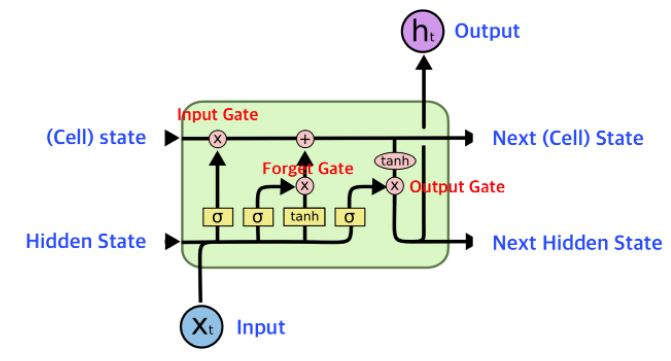

LSTM은 h와 c 두 개의 은닉 상태를 가진다.
* h: 단기 기억(이자 출력)
* c: 장기 기억


# Pointer Network 및 체크포인트 선언, 학습된 값 복원, 실험 코드

In [7]:
PN = pointer_network.PointerNetwork(UNITS, BATCH_SIZE,
                    learning_rate=LEARNING_RATE,
                    output_std=0.1,
                    dropout_rate=DROPOUT_RATE)


checkpoint_dir = "./training_checkpoints/pn" + PREFIX
checkpoint_prefix = os.path.join(checkpoint_dir, "pn")
checkpoint = tf.train.Checkpoint(**PN.get_model())

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#val_labels = np.expand_dims(val_labels, axis=-1)  # 차원 추가
#val_labels = np.tile(val_labels, [1, 10, 1])  # (18, 10, 1)로 변환
(predictions, acc) =  PN.eval(val_inputs[:1], val_labels[:1])


print("예측 id: ")
for i in range( predictions.shape[1]):
    print(predictions[0,i,0].numpy(), "", end="")
print()
print("정답 id: ")
for i in range(val_labels.shape[1]):
    print(val_labels[0,i], "", end="")

예측 id: 
2 1 9 4 0 
정답 id: 
2 1 9 4 0 

In [8]:
print(train_inputs.shape)
print(train_labels.shape)

print(val_inputs.shape)
print(val_labels.shape)

(90, 10, 40, 50, 1)
(90, 5)
(9, 10, 40, 50, 1)
(9, 5)


# 검증 코드

In [9]:
import matplotlib.pyplot as plt

def array_similarity(arr1, arr2): ## 배열 유사도
    assert len(arr1) == len(arr2)

    match_count = 0
    length = len(arr1)
    for i in range(length):
        if arr1[i] == arr2[i]:
            match_count += 1

    return match_count / length


def validation_print(k=3, N=1, show_img=False):
    acc = 0.0
    total_similarity = 0.0

    inp, lab = val_inputs, val_labels

    for n_samples in range(N):
        result, n_samples = PN.eval(inp, lab)
        #top_k_probs, top_k_indices = top_k_predictions(PN, inp, k=k)
        acc += n_samples
    
        acc = acc / N
        print("Evaluation: ")
        print("acc: ", acc)

        for i in range(val_inputs.shape[0]):
            pred_arr = [result[i, j, 0] - 1 for j in range(result.shape[1])]
            targ_arr = [lab[i, j] - 1 for j in range(DEC_MAX_STEP)]

            similarity = array_similarity(pred_arr, targ_arr)
            total_similarity += similarity

            if show_img:
                plt.imshow(val_orig[i])
                plt.show()

            print("=====================sample {0}=====================".format(i + 1))

            r_str = "pred: [{}]".format(" ".join("{:^3}".format(x) for x in pred_arr))
            t_str = "targ: [{}]".format(" ".join("{:^3}".format(x) for x in targ_arr))
            s_str = "배열 유사도: {:.2f}".format(similarity)


            print(r_str)
            print(t_str)
            print(s_str)

            

    avg_similarity = total_similarity / (val_inputs.shape[0] * N)
    #acc = acc / (val_inputs.shape[0] * N)

    #print("\nacc: ", acc)
    print("배열 유사도 평균치: {:.2f}".format(avg_similarity))
    print("----------------------------------")

    return acc


    

In [11]:
#검증

Evaluation: 
acc:  0.6666666666666666


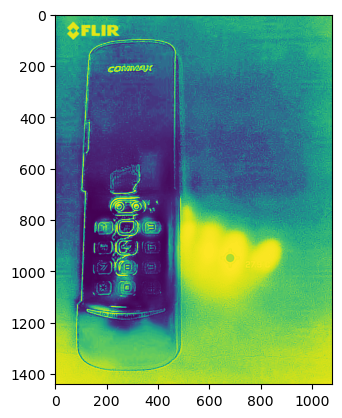

=====================sample 1=====================
pred: [ 1   0   8   3  -1 ]
targ: [ 1   0   8   3  -1 ]
배열 유사도: 1.00


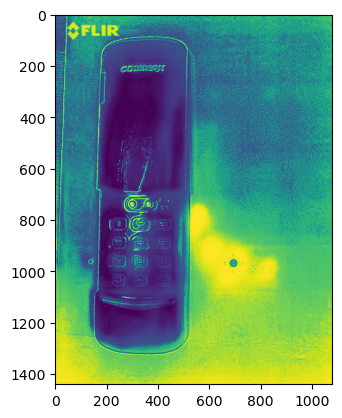

=====================sample 2=====================
pred: [ 2   5   8   7  -1 ]
targ: [ 2   5   8   7  -1 ]
배열 유사도: 1.00


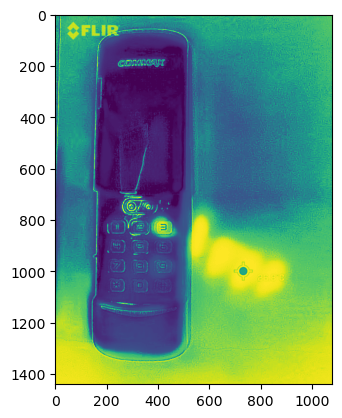

=====================sample 3=====================
pred: [ 3   3   9   3  -1 ]
targ: [ 3   3   9   3  -1 ]
배열 유사도: 1.00


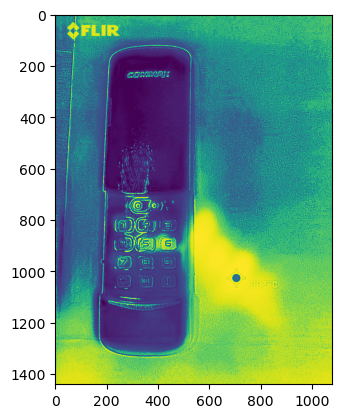

=====================sample 4=====================
pred: [ 6   7   6   5  -1 ]
targ: [ 6   7   1   5  -1 ]
배열 유사도: 0.80


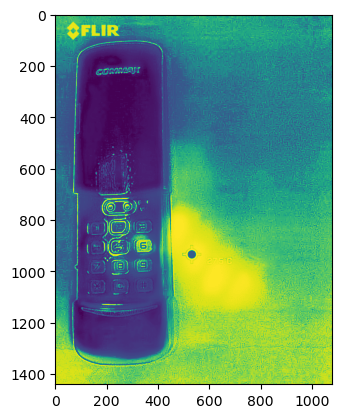

=====================sample 5=====================
pred: [ 6   9   6   9  -1 ]
targ: [ 6   8   9   2  -1 ]
배열 유사도: 0.40


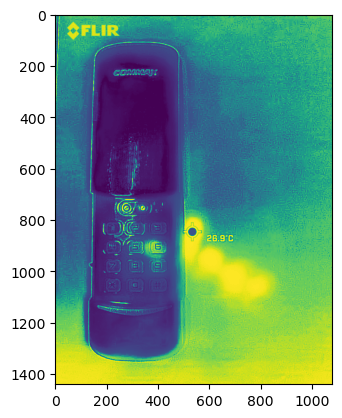

=====================sample 6=====================
pred: [ 6   9   6   5  -1 ]
targ: [ 6   9   6   5  -1 ]
배열 유사도: 1.00


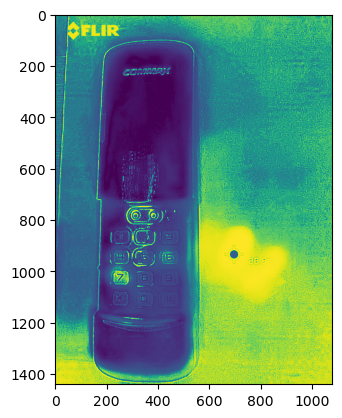

=====================sample 7=====================
pred: [ 7   4   7   6  -1 ]
targ: [ 7   4   7   6  -1 ]
배열 유사도: 1.00


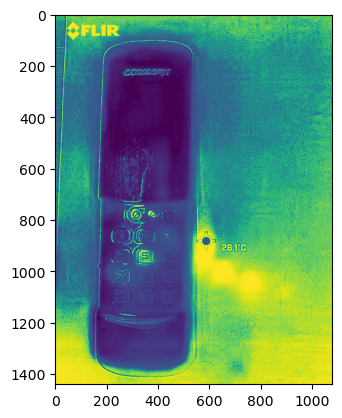

=====================sample 8=====================
pred: [ 7   5   3   5  -1 ]
targ: [ 7   5   3   5  -1 ]
배열 유사도: 1.00


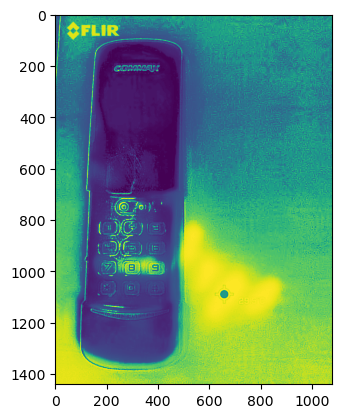

=====================sample 9=====================
pred: [ 8   9   9   9  -1 ]
targ: [ 8   9   9   7  -1 ]
배열 유사도: 0.80
배열 유사도 평균치: 0.89
----------------------------------


0.6666666666666666

In [12]:
validation_print(show_img=True)

In [ ]:
#학습하기
for epoch in range(100):
    start = time.time()
    total_loss = 0
    rand_idx = np.arange(train_inputs.shape[0])

    np.random.shuffle(rand_idx)
    
    for batch in range(STEPS_PER_EPOCH):
      
        inp, targ = train_batcher.get_batch(BATCH_SIZE)

        batch_loss = PN.step(inp, targ, clipping_value = CLIPPING_VALUE)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                             batch_loss.numpy()))
        #if batch % 1000 == 0:
    #if (epoch+1)%10 == 0:
      #validation_print()

    # saving (checkpoint) the model every 2 epochs
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss/ STEPS_PER_EPOCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

In [ ]:
#검증
validation_print(show_img=True)

# Convex hull 그리기

In [ ]:
import matplotlib.pyplot as plt

def plot_convex_hull(inp, targ, pred):

  fig = plt.figure(figsize=[12, 6])

  ax = plt.subplot(1, 2, 1)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, targ.shape[0]):
    if targ[mx] == 0:
      break;

  plt.plot(inp[targ[:mx]-1, 0], inp[targ[:mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Label")

  ax = plt.subplot(1, 2, 2)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, pred.shape[0]):
    if pred[mx] <= 0:
      break;

  plt.plot(inp[pred[:mx]-1, 0], inp[pred[ :mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Prediction")


In [ ]:
#draw convex hull

n_samples = 10

predictions, _ = PN.eval(val_inputs[:n_samples], val_labels[:n_samples])

for i in range(n_samples):
  plot_convex_hull(val_inputs[i], val_labels[i], predictions[i])

In [ ]:
import cv2
import numpy as np

def preprocess_image(image_path, target_size=(128, 128)):
    # 이미지 읽기
    img = cv2.imread(image_path)

    # 필요한 경우 전처리를 적용합니다.
    # 예: gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # median = cv2.medianBlur(gray, 5)

    # 이미지 크기 조절
    img_resized = cv2.resize(img, target_size)

    # 이미지 정규화
    img_normalized = img_resized.astype('float32') / 255.0

    # 차원 추가 (배치 크기를 위한 차원)
    img_expanded = np.expand_dims(img_normalized, axis=0)

    return img_expanded

def predict_image(image_path):
    # 이미지 전처리
    processed_img = preprocess_image(image_path)

    # 모델을 사용하여 예측 수행
    predictions, _ = PN.eval(processed_img, np.zeros((1, 10, 1)))  # 더미 레이블을 제공함
    
    # 예측 결과 출력
    print("예측 id:")
    for i in range(predictions.shape[1]):
        print(predictions[0, i, 0].numpy(), "", end="")
    print()

# 사용 예시
#image_path = 
#predict_image(image_path)

In [ ]:
# 예측할 이미지를 로드하고 전처리
input_image = load_and_preprocess_image("path/to/image.jpg")

# 입력 이미지의 배치 차원을 추가
input_batch = tf.expand_dims(input_image, axis=0)

# 상위 3개의 예측 결과를 얻음
top_k_probs, top_k_indices = top_k_predictions(PN, input_batch, k=3)

# 결과 출력
print("Top-3 predictions:", top_k_indices.numpy())
print("Probabilities:", top_k_probs.numpy())